## 📚 Prerequisites

Ensure that your Azure Services are properly set up, your Conda environment is created, and your environment variables are configured as per the instructions in the [SETTINGS.md](SETTINGS.md) file.

The objective of this notebook is to demonstrate how Optical Character Recognition (OCR) can be strategically employed to automate the extraction of key information from a diverse collection of invoices. This process aims to streamline data retrieval, enhancing efficiency and accuracy in processing financial documents.

We are going to use invoices located in `utils\data\bills`.

## 📋 Table of Contents

1. **OCR with Document Intelligence**: We'll utilize the `prebuilt-invoice` model from Document Intelligence to perform OCR on invoice documents.

2. **OCR using GPT-4 + Vision**: To expand our approach and embrace multimodality, we'll also use a combination of GPT-4V(Vision) for OCR. This method presents a more human-like approach to OCR, as it doesn't just extract text but also gathers contextualized details from the image, relating content in a way that mirrors human understanding.

3. **Quantitative Comparison**: Following the extraction process, we'll conduct a quantitative analysis to evaluate the performance of both methods. This will involve comparing the extracted data against the ground truth to assess the accuracy and effectiveness of each approach.



In [14]:
import os
import json
import pprint

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbbai-azure-ai-document-intelligence"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-azure-ai-document-intelligence


## OCR with Document Intelligence

In [15]:
from src.ocr.document_intelligence import AzureDocumentIntelligenceManager

document_intelligence_client = AzureDocumentIntelligenceManager()

In [16]:
document_blob = "https://testeastusdev001.blob.core.windows.net/bills/Petr1.JPG"
model_type = "prebuilt-invoice"

result_ocr_invoice_document_intelligence = (
    document_intelligence_client.analyze_document(
        document_input=document_blob,
        model_type=model_type,
        output_format="markdown",
        features=["OCR_HIGH_RESOLUTION"],
    )
)

2024-03-06 23:03:38,072 - micro - MainProcess - INFO     Blob URL detected. Extracting content. (document_intelligence.py:analyze_document:148)


2024-03-06 23:03:39,498 - micro - MainProcess - INFO     Successfully downloaded blob file Petr1.JPG (blob_data_extractor.py:extract_content:88)


In [17]:
result_ocr_invoice_document_intelligence = document_intelligence_client.process_invoice(
    result_ocr_invoice_document_intelligence.documents[0]
)
pprint.pprint(result_ocr_invoice_document_intelligence)

{'AmountDue': {'confidence': None, 'content': None},
 'BillingAddress': {'confidence': None, 'content': None},
 'BillingAddressRecipient': {'confidence': None, 'content': None},
 'CustomerAddress': {'confidence': None, 'content': None},
 'CustomerAddressRecipient': {'confidence': None, 'content': None},
 'CustomerId': {'confidence': None, 'content': None},
 'CustomerName': {'confidence': None, 'content': None},
 'DueDate': {'confidence': None, 'content': None},
 'InvoiceDate': {'confidence': 0.933, 'content': '24.04.2022'},
 'InvoiceId': {'confidence': 0.93, 'content': '108786'},
 'InvoiceTotal': {'confidence': 0.345, 'content': '€'},
 'Items': [{'Amount': {'confidence': 0.492, 'content': '3,80'},
            'Date': {'confidence': 0.865, 'content': '22.04.2022'},
            'Description': {'confidence': 0.885, 'content': 'City tax'},
            'ProductCode': {'confidence': None, 'content': None},
            'Quantity': {'confidence': None, 'content': None},
            'Tax': {'co

## OCR using GPT-4V

In [18]:
from src.ocr.transformer import GPT4VisionManager
from src.utils import clean_json_string

gpt_vision_client = GPT4VisionManager()

In [19]:
sys_message = "You are an AI assistant capable of processing complex invoices and accurately extract relevant information from images."
user_prompt = """
Please analyze the provided invoice image and extract relevant information in accordance with the given fields. 
Identify the Vendor Name, Vendor Address, Invoice ID, Invoice Date, Service Start and End Dates, Items with their Descriptions, 
Dates, and Amounts. Return the extracted data in a valid, iterable RFC8259 compliant JSON in your responses with codeblock json.
Ensure the Invoice ID is correctly extracted and matches the format expected for invoice IDs. 
Ensure to include the content for each field where applicable. 
For fields that are not available in the image, return 'null' for content. 
For the InvoiceTotal, take the sum of all individual item amounts.
For the Taxes please anlayze the VAT break down and return each of the individual taxes items in the TaxesTotalVAT field and return the key value pairs in the json file by each item and value.
For the Currency, ensure to identify the currency used in the invoice and ensure all monetary amounts are correctly interpreted in this currency. 
Calculate the Invoice Total by summing up the Amounts of all Items if not available, and verify that it matches the Invoice Total stated on the invoice. 
Identify the currency used in the invoice and ensure all monetary amounts are correctly interpreted in this currency.
All the amounts should be returned in the format "X,XXX.XX" without the currency symbol.
The Items should be extracted as an array of dictionaries, each representing an item line on the invoice with its details.

This task requires a high level of precision and attention to detail. Your ability to accurately extract and structure this data
is crucial for the subsequent processing and analysis of these invoices. Please take your time and ensure the highest level of accuracy.

Here is an example JSON structure that you would expect as a result. 
Do not include any explanations, only provide a RFC8259 compliant JSON response following this format without deviation.

## Example JSON Structure
{
  "VendorName": {
    "content": "Hotel Magnetberg Baden-Baden",
  },
  "VendorAddress": {
    "content": "Scheibenstr. 18\nD-76530 Baden-Baden",
  },
  "VendorAddressRecipient": {
    "content": "Hotel Magnetberg Baden-Baden",
  },
  "CustomerName": {
    "content": null,
  },
  "CustomerId": {
    "content": null,
  },
  "TaxesTotalVAT": {
    "content": [
        "21,00","7,60","29,00"
    ],
  },
  "CustomerAddress": {
    "content": null,
  },
  "CustomerAddressRecipient": {
    "content": null,
  },
  "InvoiceId": {
    "content": "108786",
  },
  "InvoiceDate": {
    "content": "24.04.2022",
  },
  "InvoiceTotal": {
    "content": "6,00",
  },
  "Currency": { 
    "content": "EUR",
  },
  "DueDate": {
    "content": null,
  },
  "PurchaseOrder": {
    "content": null,
  },
  "BillingAddress": {
    "content": null,
  },
  "BillingAddressRecipient": {
    "content": null,
  },
  "ShippingAddress": {
    "content": null,
  },
  "ShippingAddressRecipient": {
    "content": null,
  },
  "SubTotal": {
    "content": null,
  },
  "TotalTax": {
    "content": "6,00",
  },
  "PreviousUnpaidBalance": {
    "content": null,
  },
  "AmountDue": {
    "content": null,
  },
  "ServiceStartDate": {
    "content": "22.04.2022",
  },
  "ServiceEndDate": {
    "content": "24.04.2022",
  },
  "ServiceAddress": {
    "content": null,
  },
  "ServiceAddressRecipient": {
    "content": null,
  },
  "RemittanceAddress": {
    "content": null,
  },
  "RemittanceAddressRecipient": {
    "content": null,
  },
  "Items": [
    {
      "Description": {
        "content": "City tax",
      },
      "Date": {
        "content": "22.04.2022",
      },
      "Amount": {
        "content": "3,80",
      }
    }
    // ... other items
  ]
}
"""

In [20]:
document_local = "C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-document-intelligence\\utils\data\\bills\\Petr1.JPG"

2024-03-06 23:04:11,478 - micro - MainProcess - INFO     Preparing instruction for GPT-4 Vision API call. (transformer.py:prepare_instruction:137)
2024-03-06 23:04:11,483 - micro - MainProcess - INFO     Instruction: [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an AI assistant capable of processing complex invoices and accurately extract relevant information from images.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': '\nPlease analyze the provided invoice image and extract relevant information in accordance with the given fields. \nIdentify the Vendor Name, Vendor Address, Invoice ID, Invoice Date, Service Start and End Dates, Items with their Descriptions, \nDates, and Amounts. Return the extracted data in a valid, iterable RFC8259 compliant JSON in your responses with codeblock json.\nEnsure the Invoice ID is correctly extracted and matches the format expected for invoice IDs. \nEnsure to include the content for each field where applicable. \nFor fiel
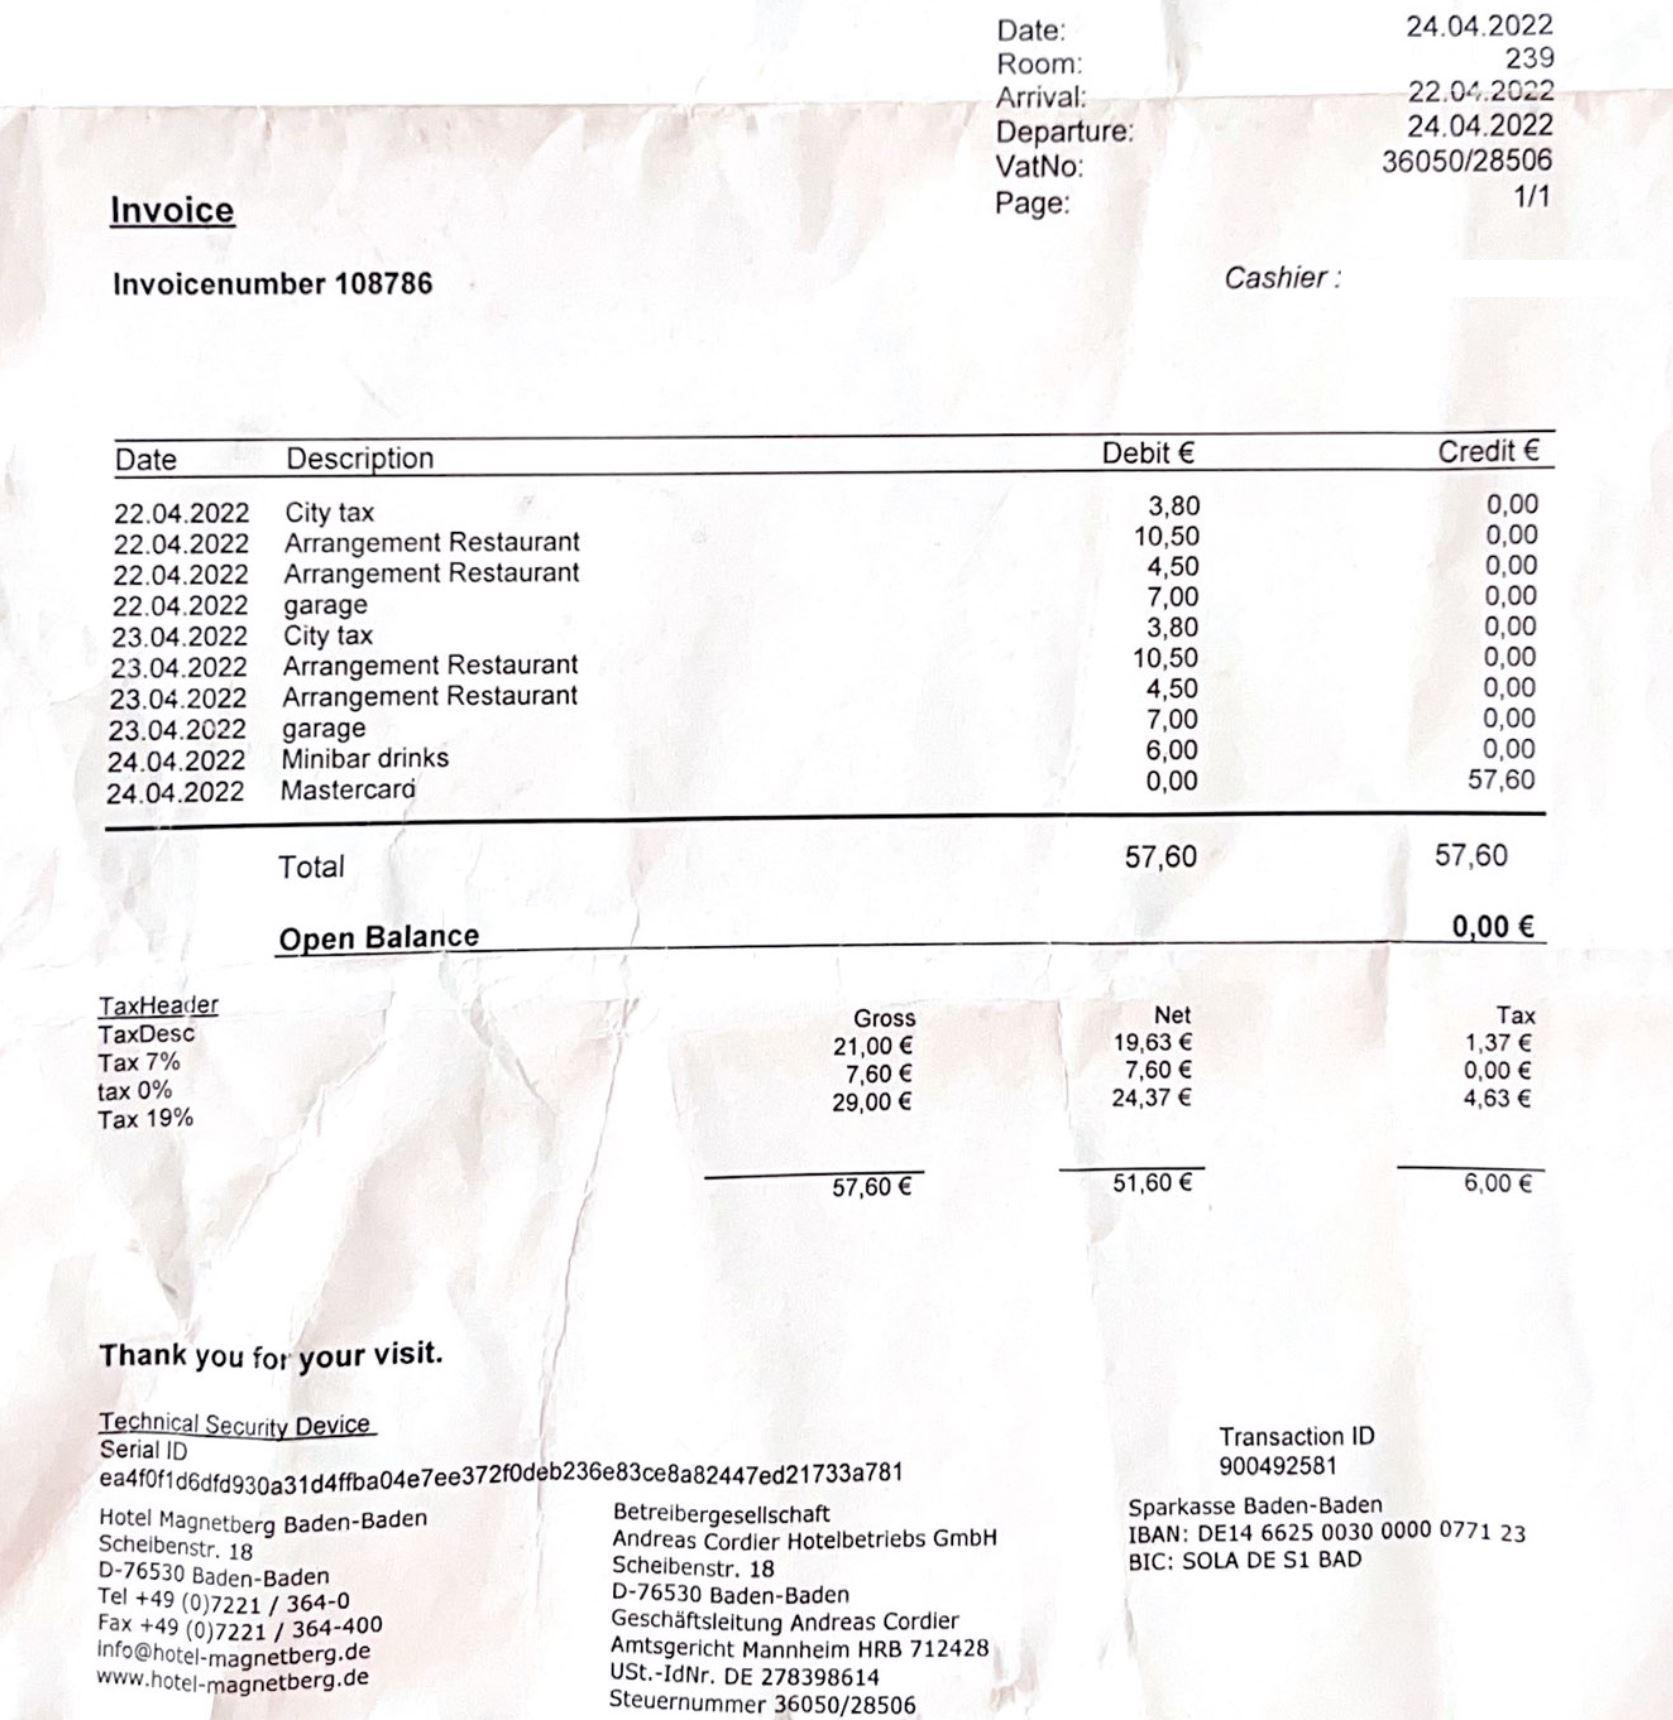

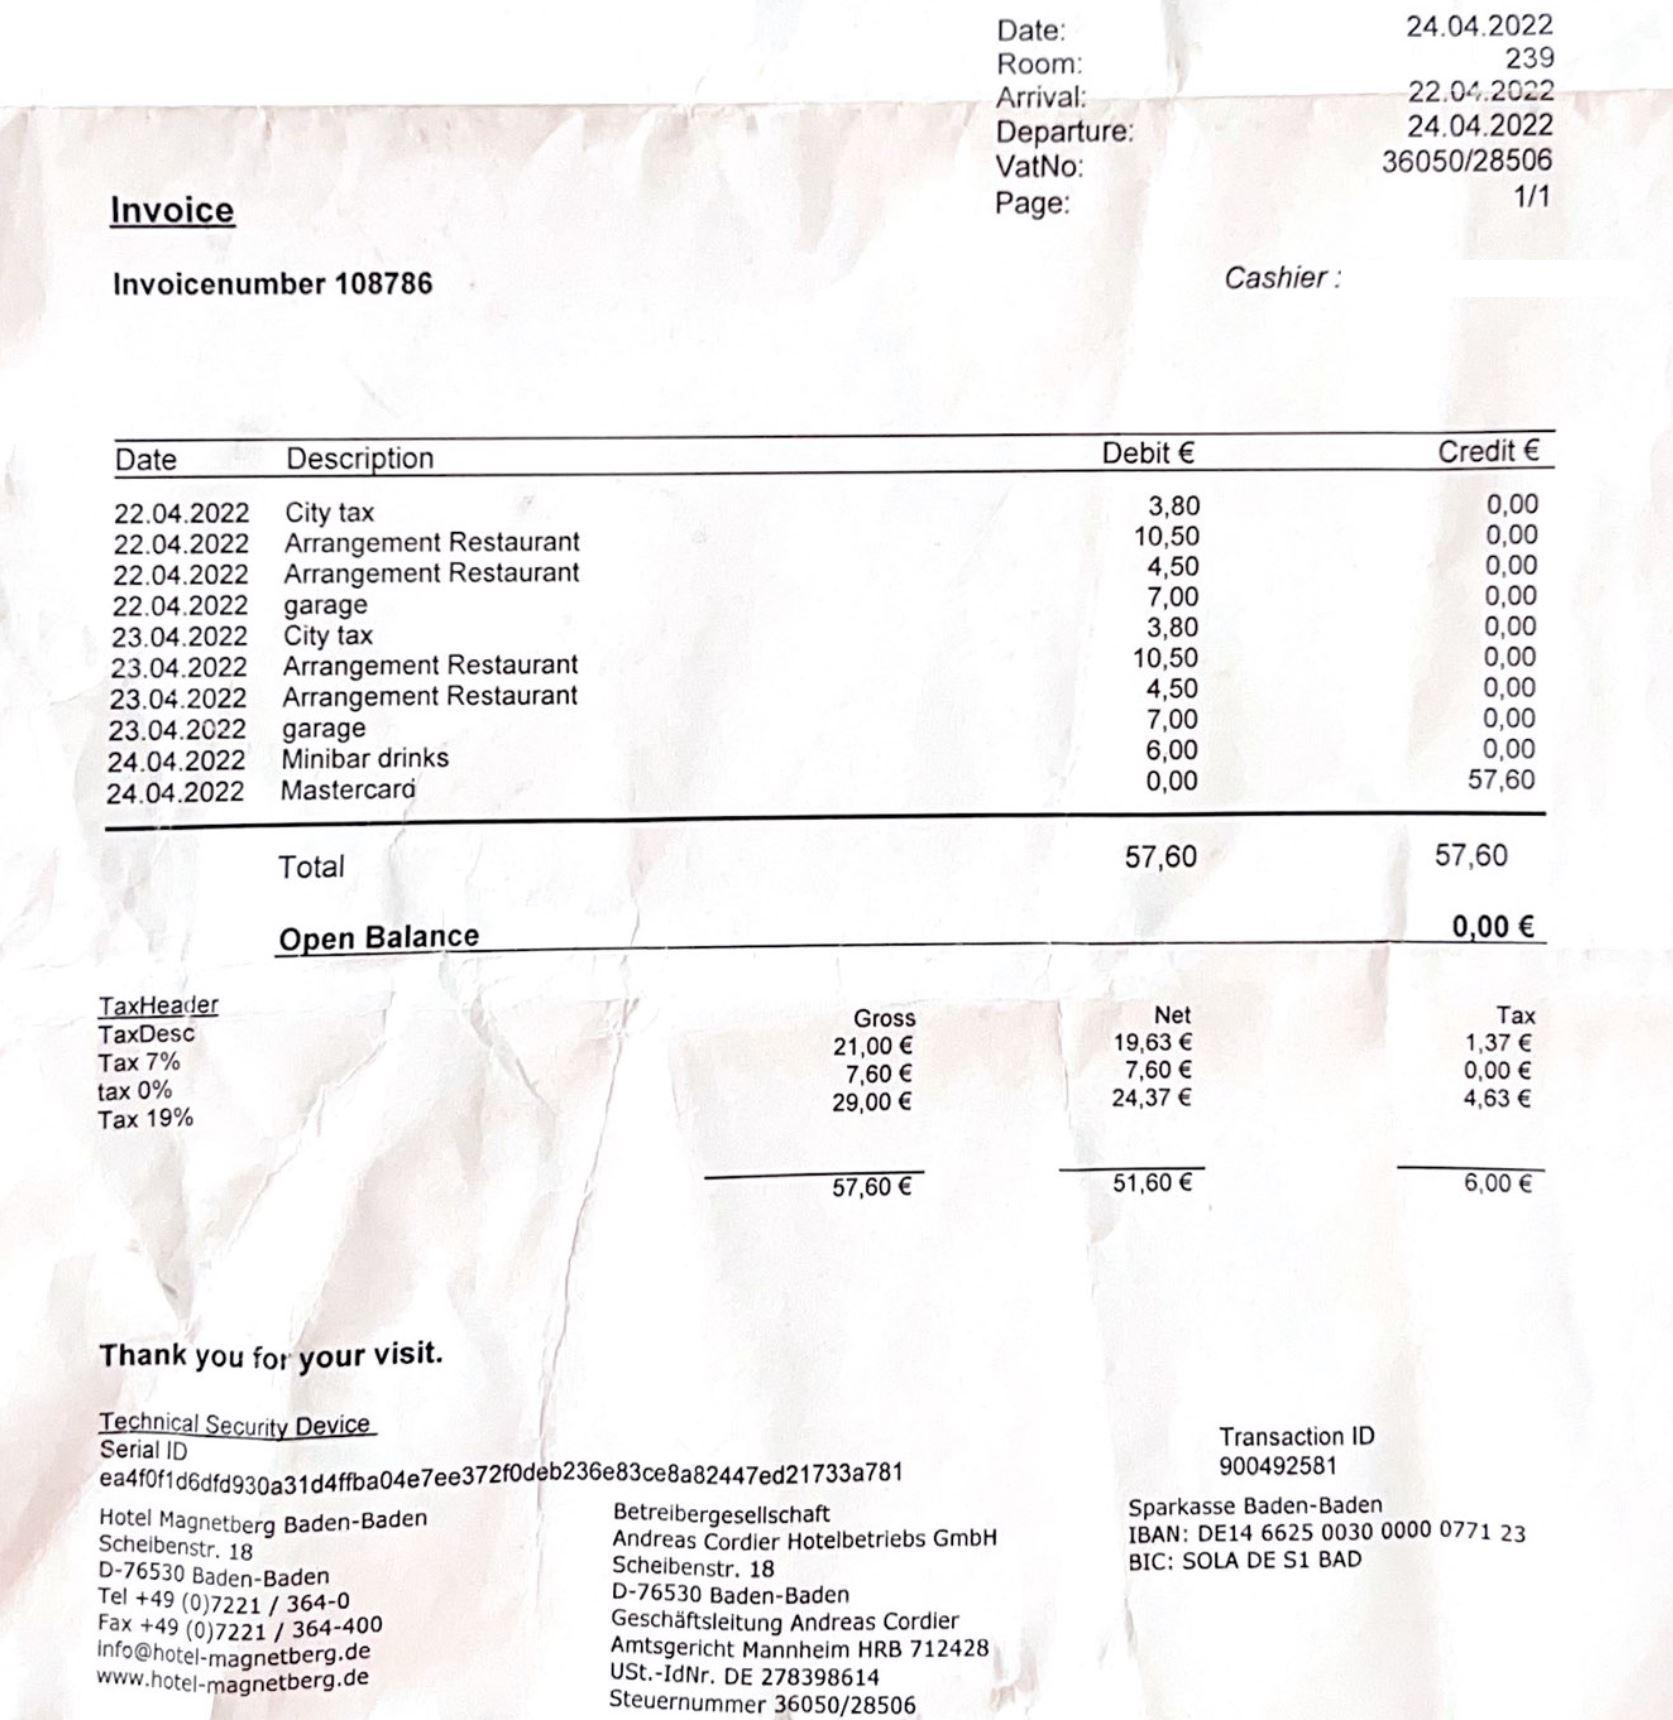

In [21]:
result_ocr_invoice_gpt_4_vision = gpt_vision_client.call_gpt4v_image(
    document_local,
    system_instruction=sys_message,
    user_instruction=user_prompt,
    ocr=True,
    use_vision_api=True,
    display_image=True,
    max_tokens=3000,
    seed=42,
)

In [22]:
# Usage
cleaned_json_string = clean_json_string(result_ocr_invoice_gpt_4_vision)
ocr_recognizer_dict = json.loads(cleaned_json_string)
pprint.pprint(ocr_recognizer_dict)

{'AmountDue': {'content': '0,00'},
 'BillingAddress': {'content': None},
 'BillingAddressRecipient': {'content': None},
 'Currency': {'content': 'EUR'},
 'CustomerAddress': {'content': None},
 'CustomerAddressRecipient': {'content': None},
 'CustomerId': {'content': None},
 'CustomerName': {'content': None},
 'DueDate': {'content': None},
 'InvoiceDate': {'content': '24.04.2022'},
 'InvoiceId': {'content': '108786'},
 'InvoiceTotal': {'content': '57,60'},
 'Items': [{'Amount': {'content': '3,80'},
            'Date': {'content': '22.04.2022'},
            'Description': {'content': 'City tax'}},
           {'Amount': {'content': '10,50'},
            'Date': {'content': '22.04.2022'},
            'Description': {'content': 'Arrangement Restaurant'}},
           {'Amount': {'content': '4,50'},
            'Date': {'content': '22.04.2022'},
            'Description': {'content': 'Arrangement Restaurant'}},
           {'Amount': {'content': '7,00'},
            'Date': {'content': '22.04.

## Testing Approach 

The `compare_invoices` function is designed to compare the results of two different OCR methods (Document Intelligence and GPT-4 Vision) against a ground truth. The testing approach based on this function would involve the following steps:

1. **Data Preparation**: Prepare a set of invoice documents and their corresponding ground truth data. The ground truth data should contain the correct values for the fields 'TotalTax', 'InvoiceTotal', 'InvoiceId', and 'InvoiceDate'.

2. **Data Extraction**: Use both the Document Intelligence and GPT-4 Vision OCR methods to extract data from the invoice documents. Each method should return a dictionary with the extracted data.

3. **Comparison**: Pass the dictionaries returned by the OCR methods and the ground truth data to the `compare_invoices` function. The function will compare the extracted data with the ground truth for each key in `keys_to_compare`.

4. **Analysis**: The `compare_invoices` function returns a dictionary with the comparison results. For each key in `keys_to_compare`, the dictionary contains the values extracted by Document Intelligence, GPT-4 Vision, and the ground truth. Analyze these results to evaluate the performance of the OCR methods.

This testing approach allows you to quantitatively compare the performance of the two OCR methods against the ground truth. It provides a clear picture of how accurately each method is able to extract key details from the invoice documents.

In [23]:
from src.utils import compare_invoices

# Define the ground truth
ground_truth = {
    "TotalTax": "6,00",
    "InvoiceTotal": "57,60",
    "InvoiceId": "108786",
    "InvoiceDate": "24.04.2022",
}

# Compare the dictionaries
comparison_result = compare_invoices(
    invoice_document_intelligence=result_ocr_invoice_document_intelligence,
    invoice_gpt4_vision=ocr_recognizer_dict,
    ground_truth=ground_truth,
)
comparison_result

{'TotalTax': {'invoice_document_intelligence': '6,00 €',
  'invoice_gpt4_vision': '6,00',
  'ground_truth': '6,00'},
 'InvoiceTotal': {'invoice_document_intelligence': '€',
  'invoice_gpt4_vision': '57,60',
  'ground_truth': '57,60'},
 'InvoiceId': {'invoice_document_intelligence': '108786',
  'invoice_gpt4_vision': '108786',
  'ground_truth': '108786'},
 'InvoiceDate': {'invoice_document_intelligence': '24.04.2022',
  'invoice_gpt4_vision': '24.04.2022',
  'ground_truth': '24.04.2022'}}

### Bulk Invoice Test

In this section, we will conduct a comprehensive test to evaluate the performance of our OCR methods. We will process multiple invoices located in the `utils\data\bills` directory. 

The ground truth data for these invoices has been manually extracted and will serve as the benchmark for our OCR methods. By comparing the OCR results with the ground truth, we can quantitatively assess the accuracy of our methods. 

This comprehensive test will provide valuable insights into the effectiveness of our OCR methods when applied to a diverse set of real-world invoices.

In [27]:
document_local = "C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-document-intelligence\\utils\data\\bills\\"
document_blob = "https://testeastusdev001.blob.core.windows.net/bills/"
document_names = [
    "Petr1.JPG",
    "Hotel119.jpg",
    "5137.jpg",
    "5016.jpg",
    "5097.jpg",
]

In [28]:
ground_truth_bulk = {
    "Petr1.JPG": {
        "TotalTax": "6,00",
        "InvoiceTotal": "57,60",
        "InvoiceId": "108786",
        "InvoiceDate": "24.04.2022",
    },
    "Hotel119.jpg": {
        "TotalTax": "20.18",
        "InvoiceTotal": "271.35",
        "InvoiceId": "1173868",
        "InvoiceDate": "11.10.18",
    },
    "5137.jpg": {
        "TotalTax": "40.55",
        "InvoiceTotal": "449.75",
        "InvoiceId": "268690",
        "InvoiceDate": "21.06.22",
    },
    "5016.jpg": {
        "TotalTax": "127.61",
        "InvoiceTotal": "1,722.67",
        "InvoiceId": "42454052022PPH",
        "InvoiceDate": "2022-05-27",
    },
    "5097.jpg": {
        "TotalTax": "20.74",
        "InvoiceTotal": "0.00",
        "InvoiceId": "647322009194",
        "InvoiceDate": "20.04.22",
    },
    "Hotel122.jpg": {
        "TotalTax": "194.00",
        "InvoiceTotal": "1,845.70",
        "InvoiceId": "147914",
        "InvoiceDate": "28/09/2018",
    },
}

2024-03-06 23:11:22,265 - micro - MainProcess - INFO     Blob URL detected. Extracting content. (document_intelligence.py:analyze_document:148)
2024-03-06 23:11:22,332 - micro - MainProcess - INFO     Successfully downloaded blob file Petr1.JPG (blob_data_extractor.py:extract_content:88)


2024-03-06 23:11:52,965 - micro - MainProcess - INFO     Preparing instruction for GPT-4 Vision API call. (transformer.py:prepare_instruction:137)
2024-03-06 23:11:52,965 - micro - MainProcess - INFO     Instruction: [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an AI assistant capable of processing complex invoices and accurately extract relevant information from images.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': '\nPlease analyze the provided invoice image and extract relevant information in accordance with the given fields. \nIdentify the Vendor Name, Vendor Address, Invoice ID, Invoice Date, Service Start and End Dates, Items with their Descriptions, \nDates, and Amounts. Return the extracted data in a valid, iterable RFC8259 compliant JSON in your responses with codeblock json.\nEnsure the Invoice ID is correctly extracted and matches the format expected for invoice IDs. \nEnsure to include the content for each field where applicable. \nFor fiel
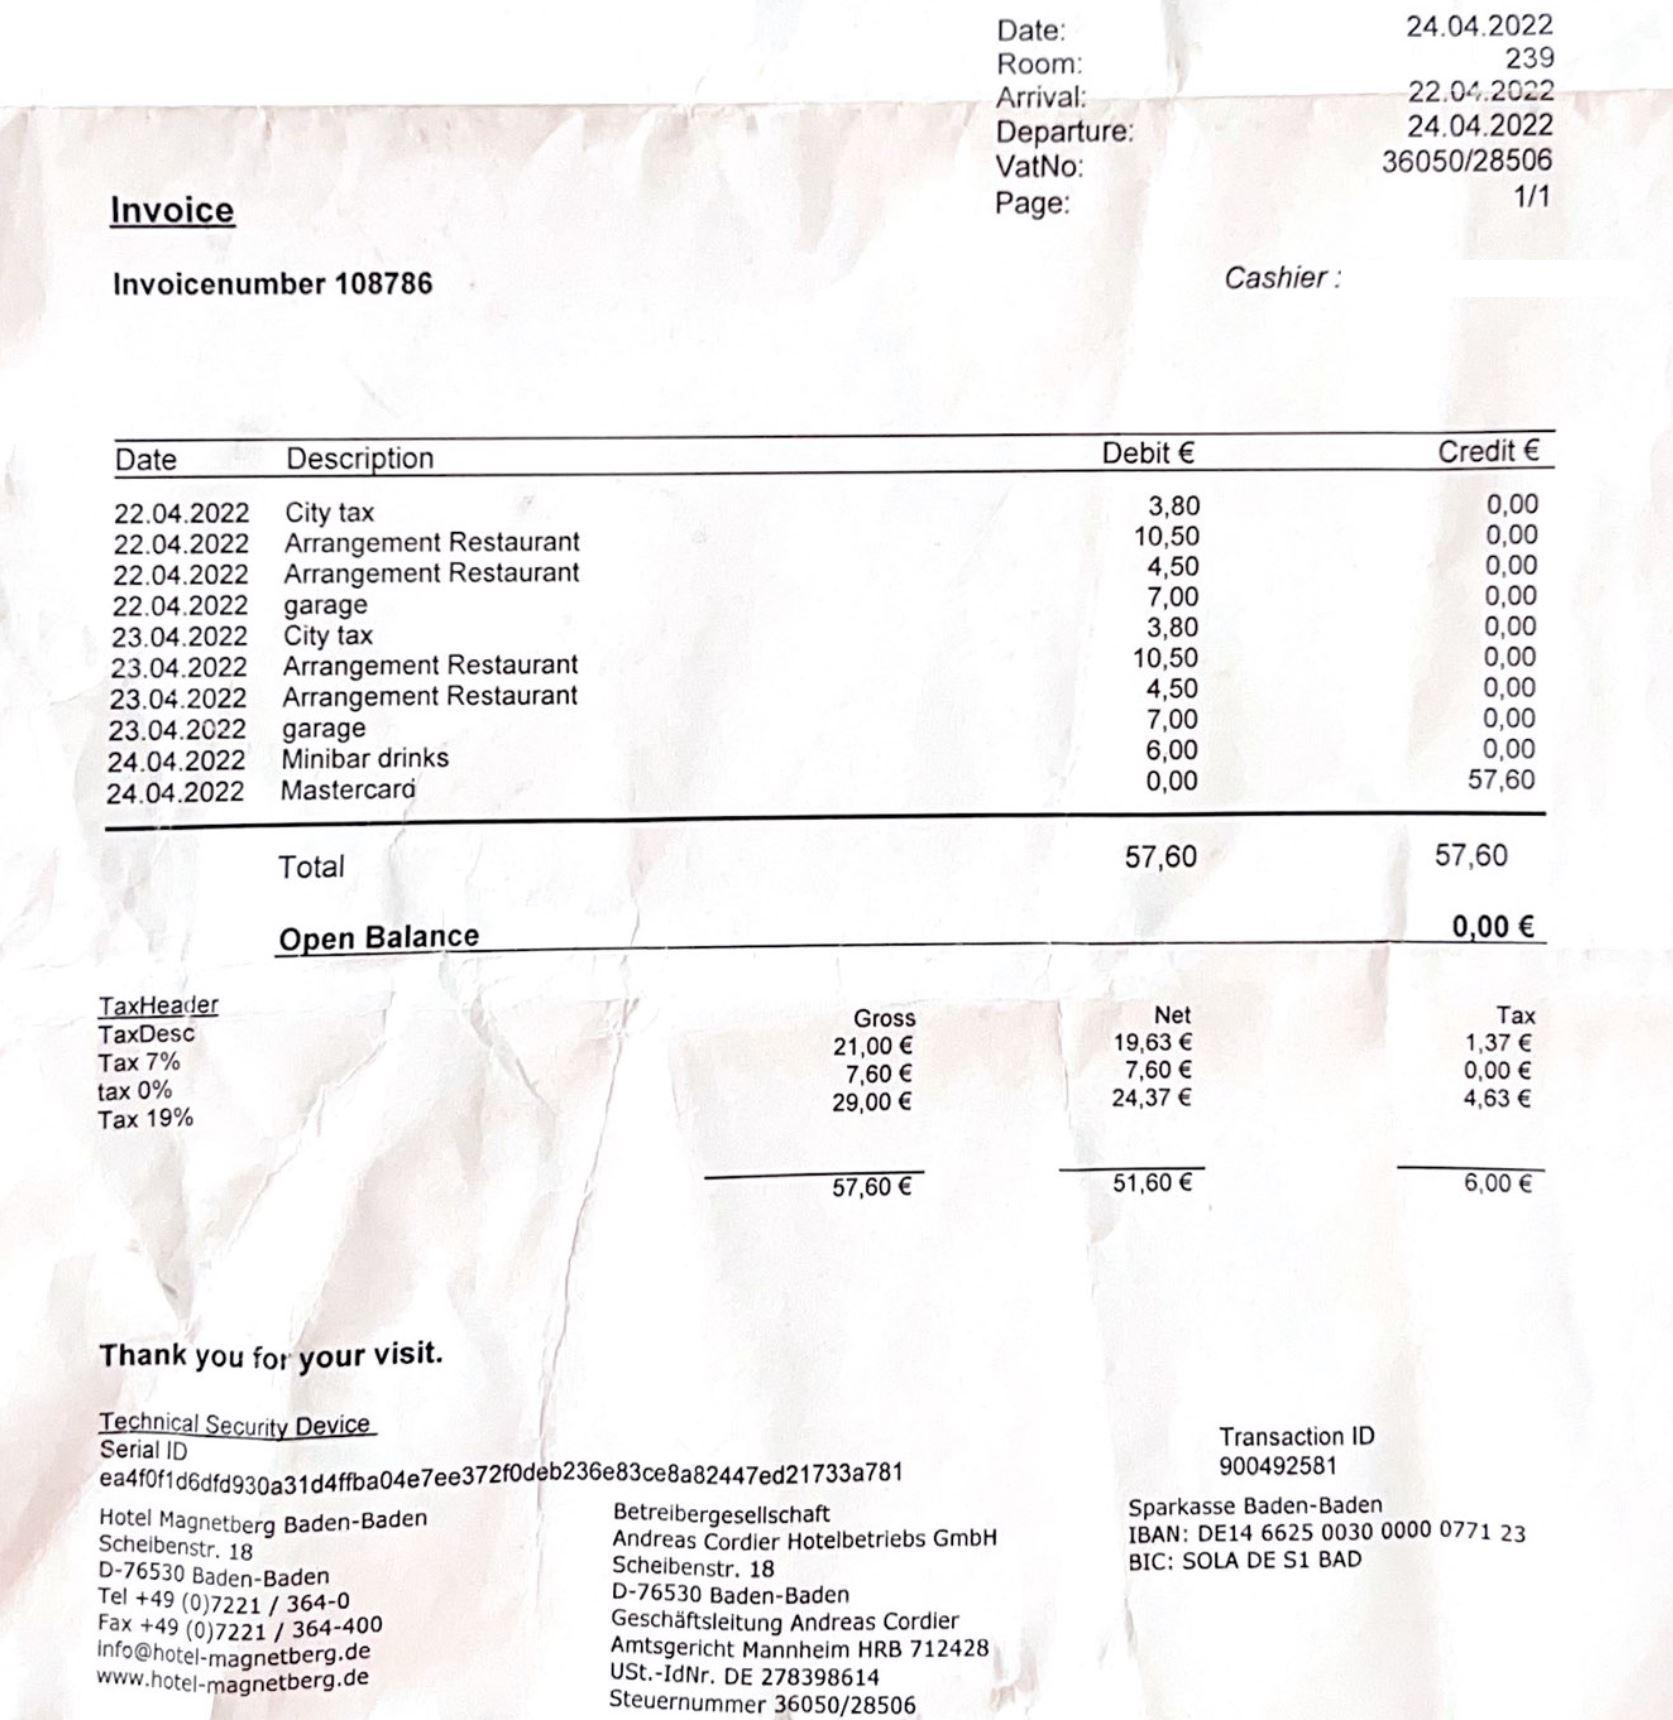
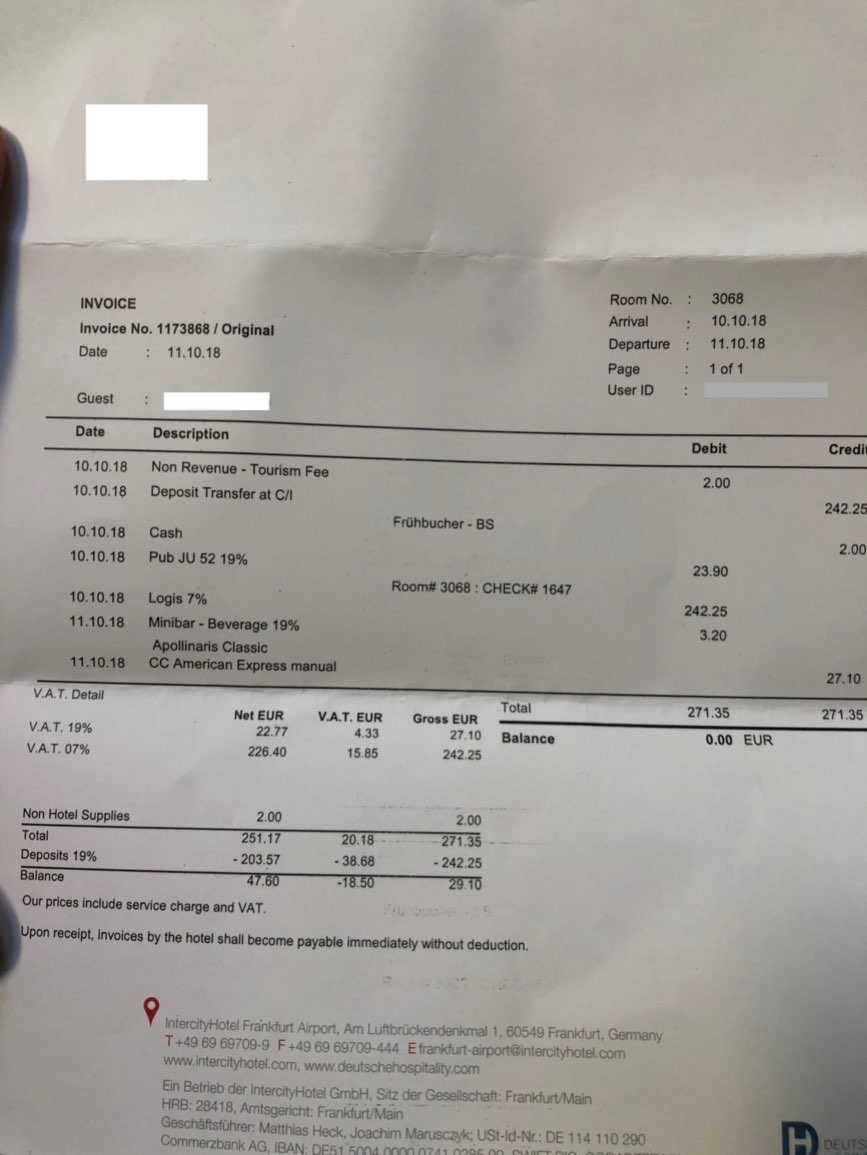
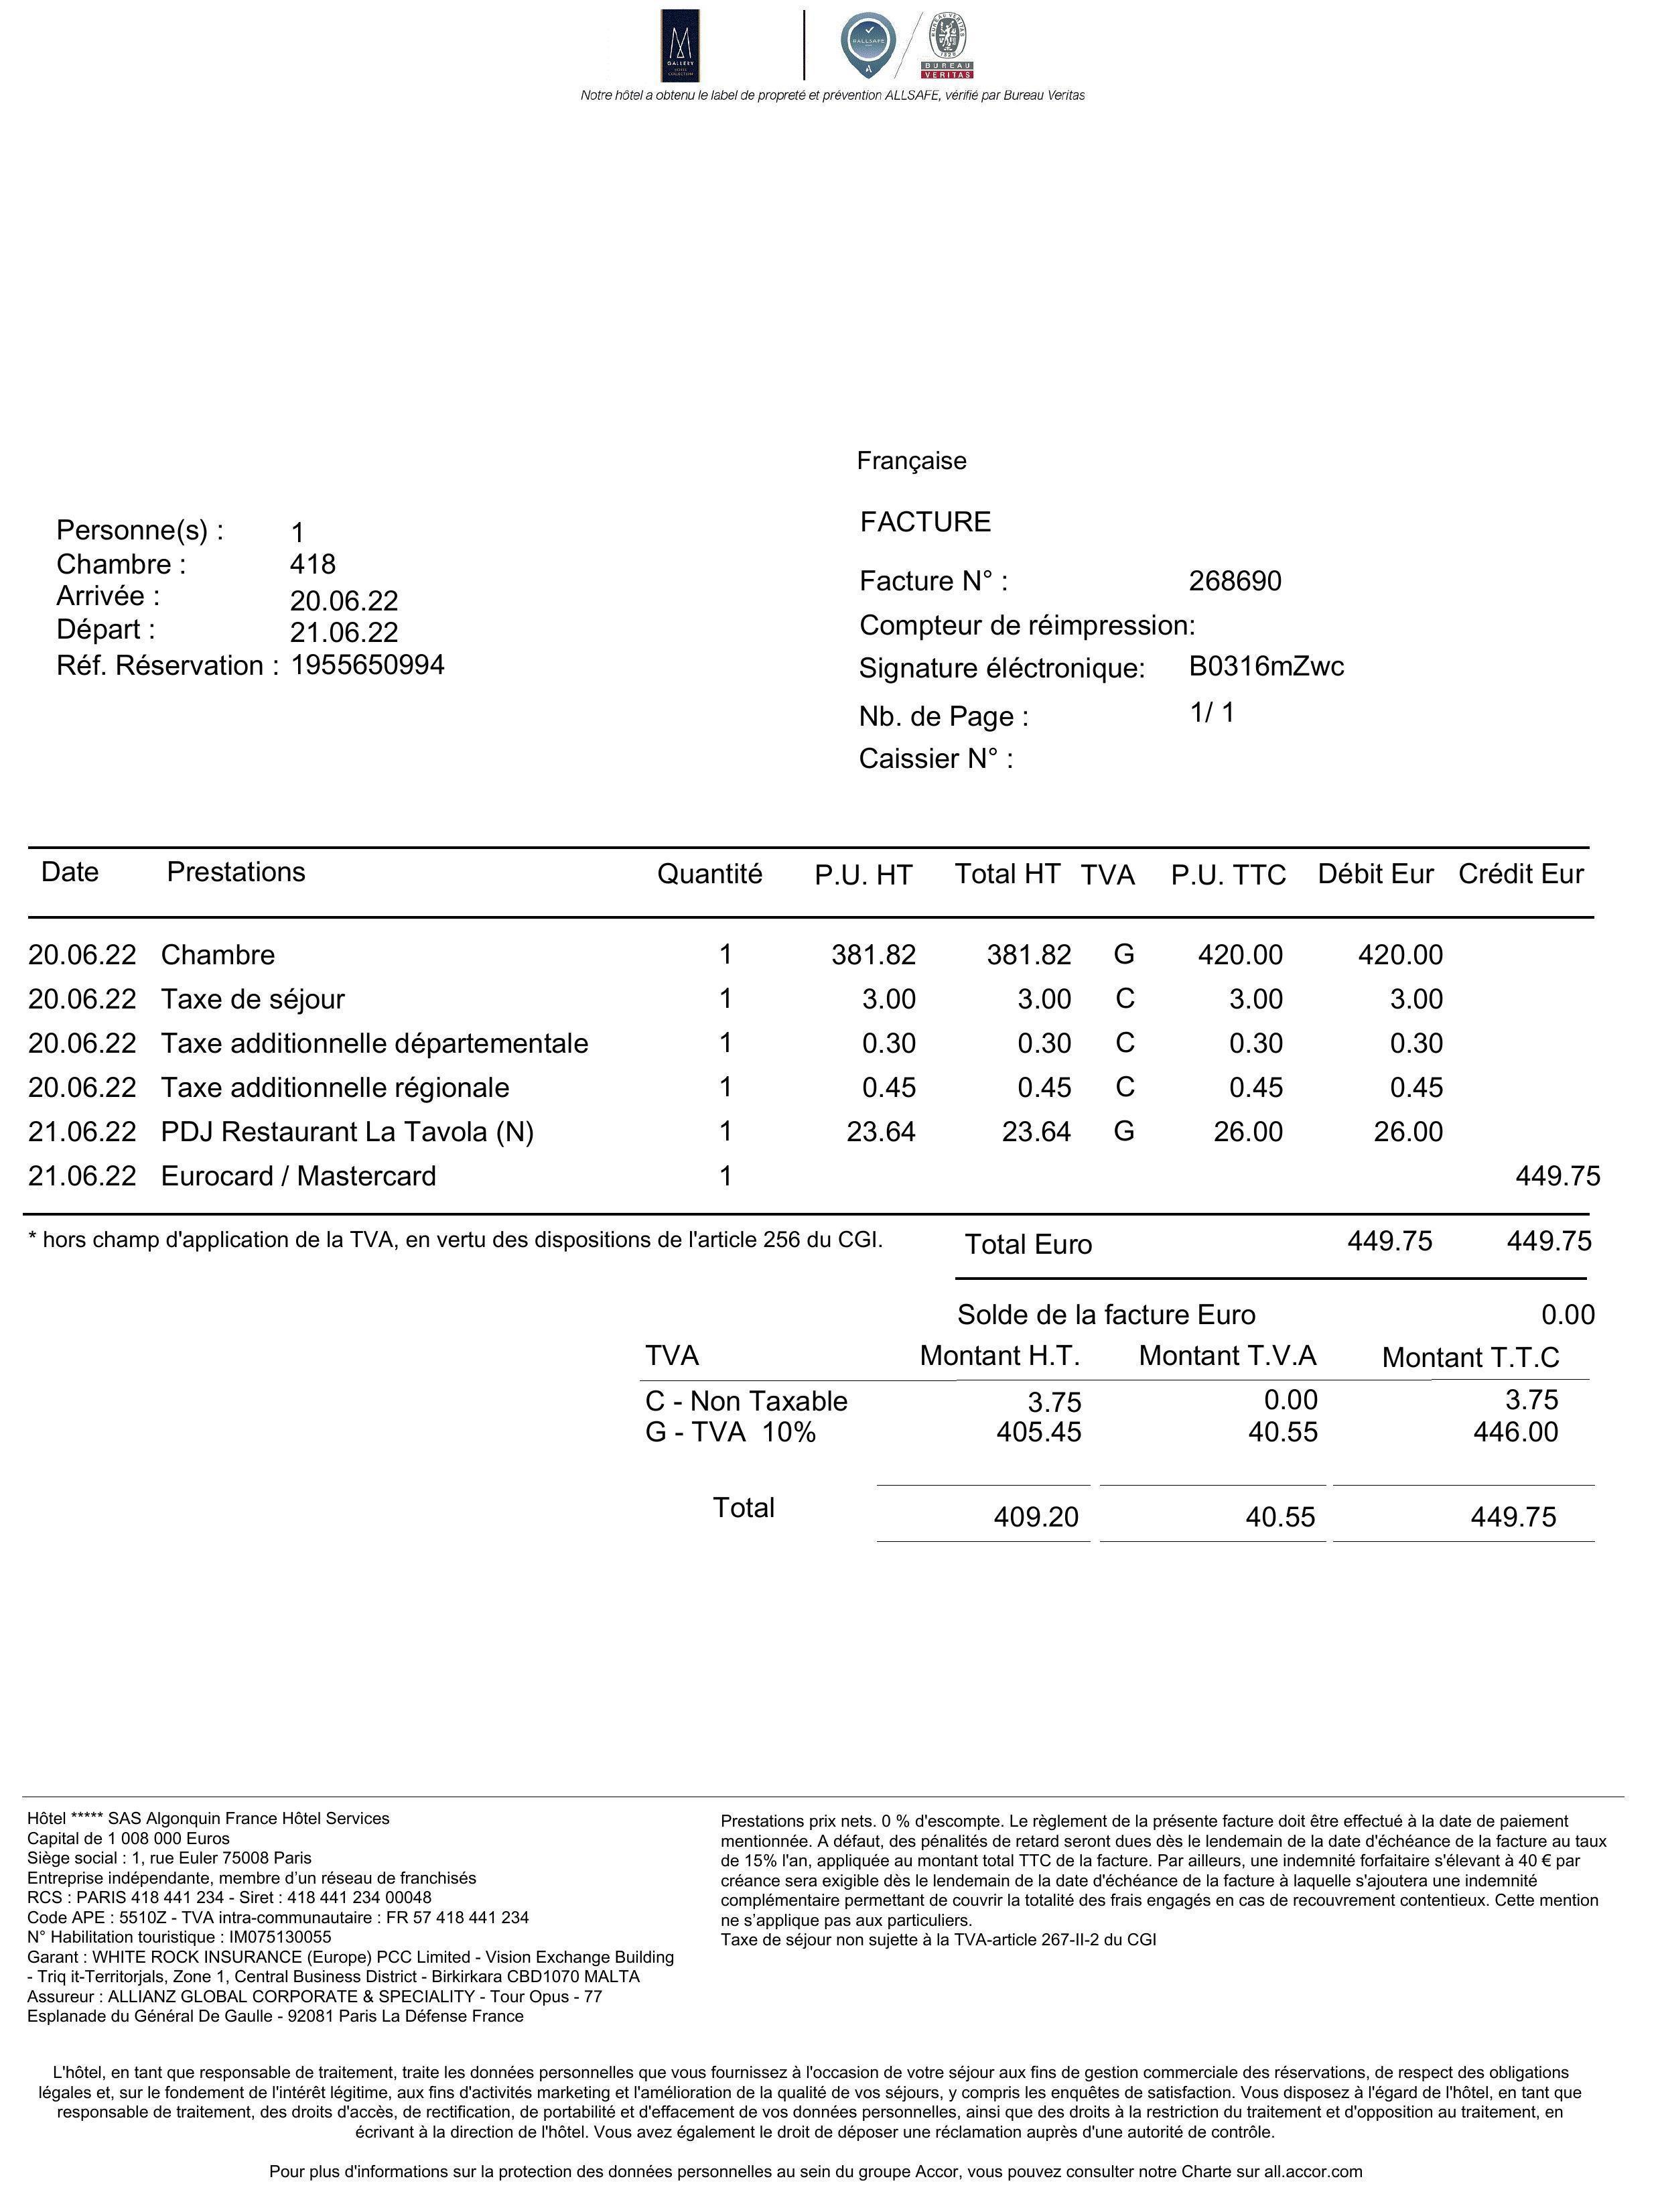
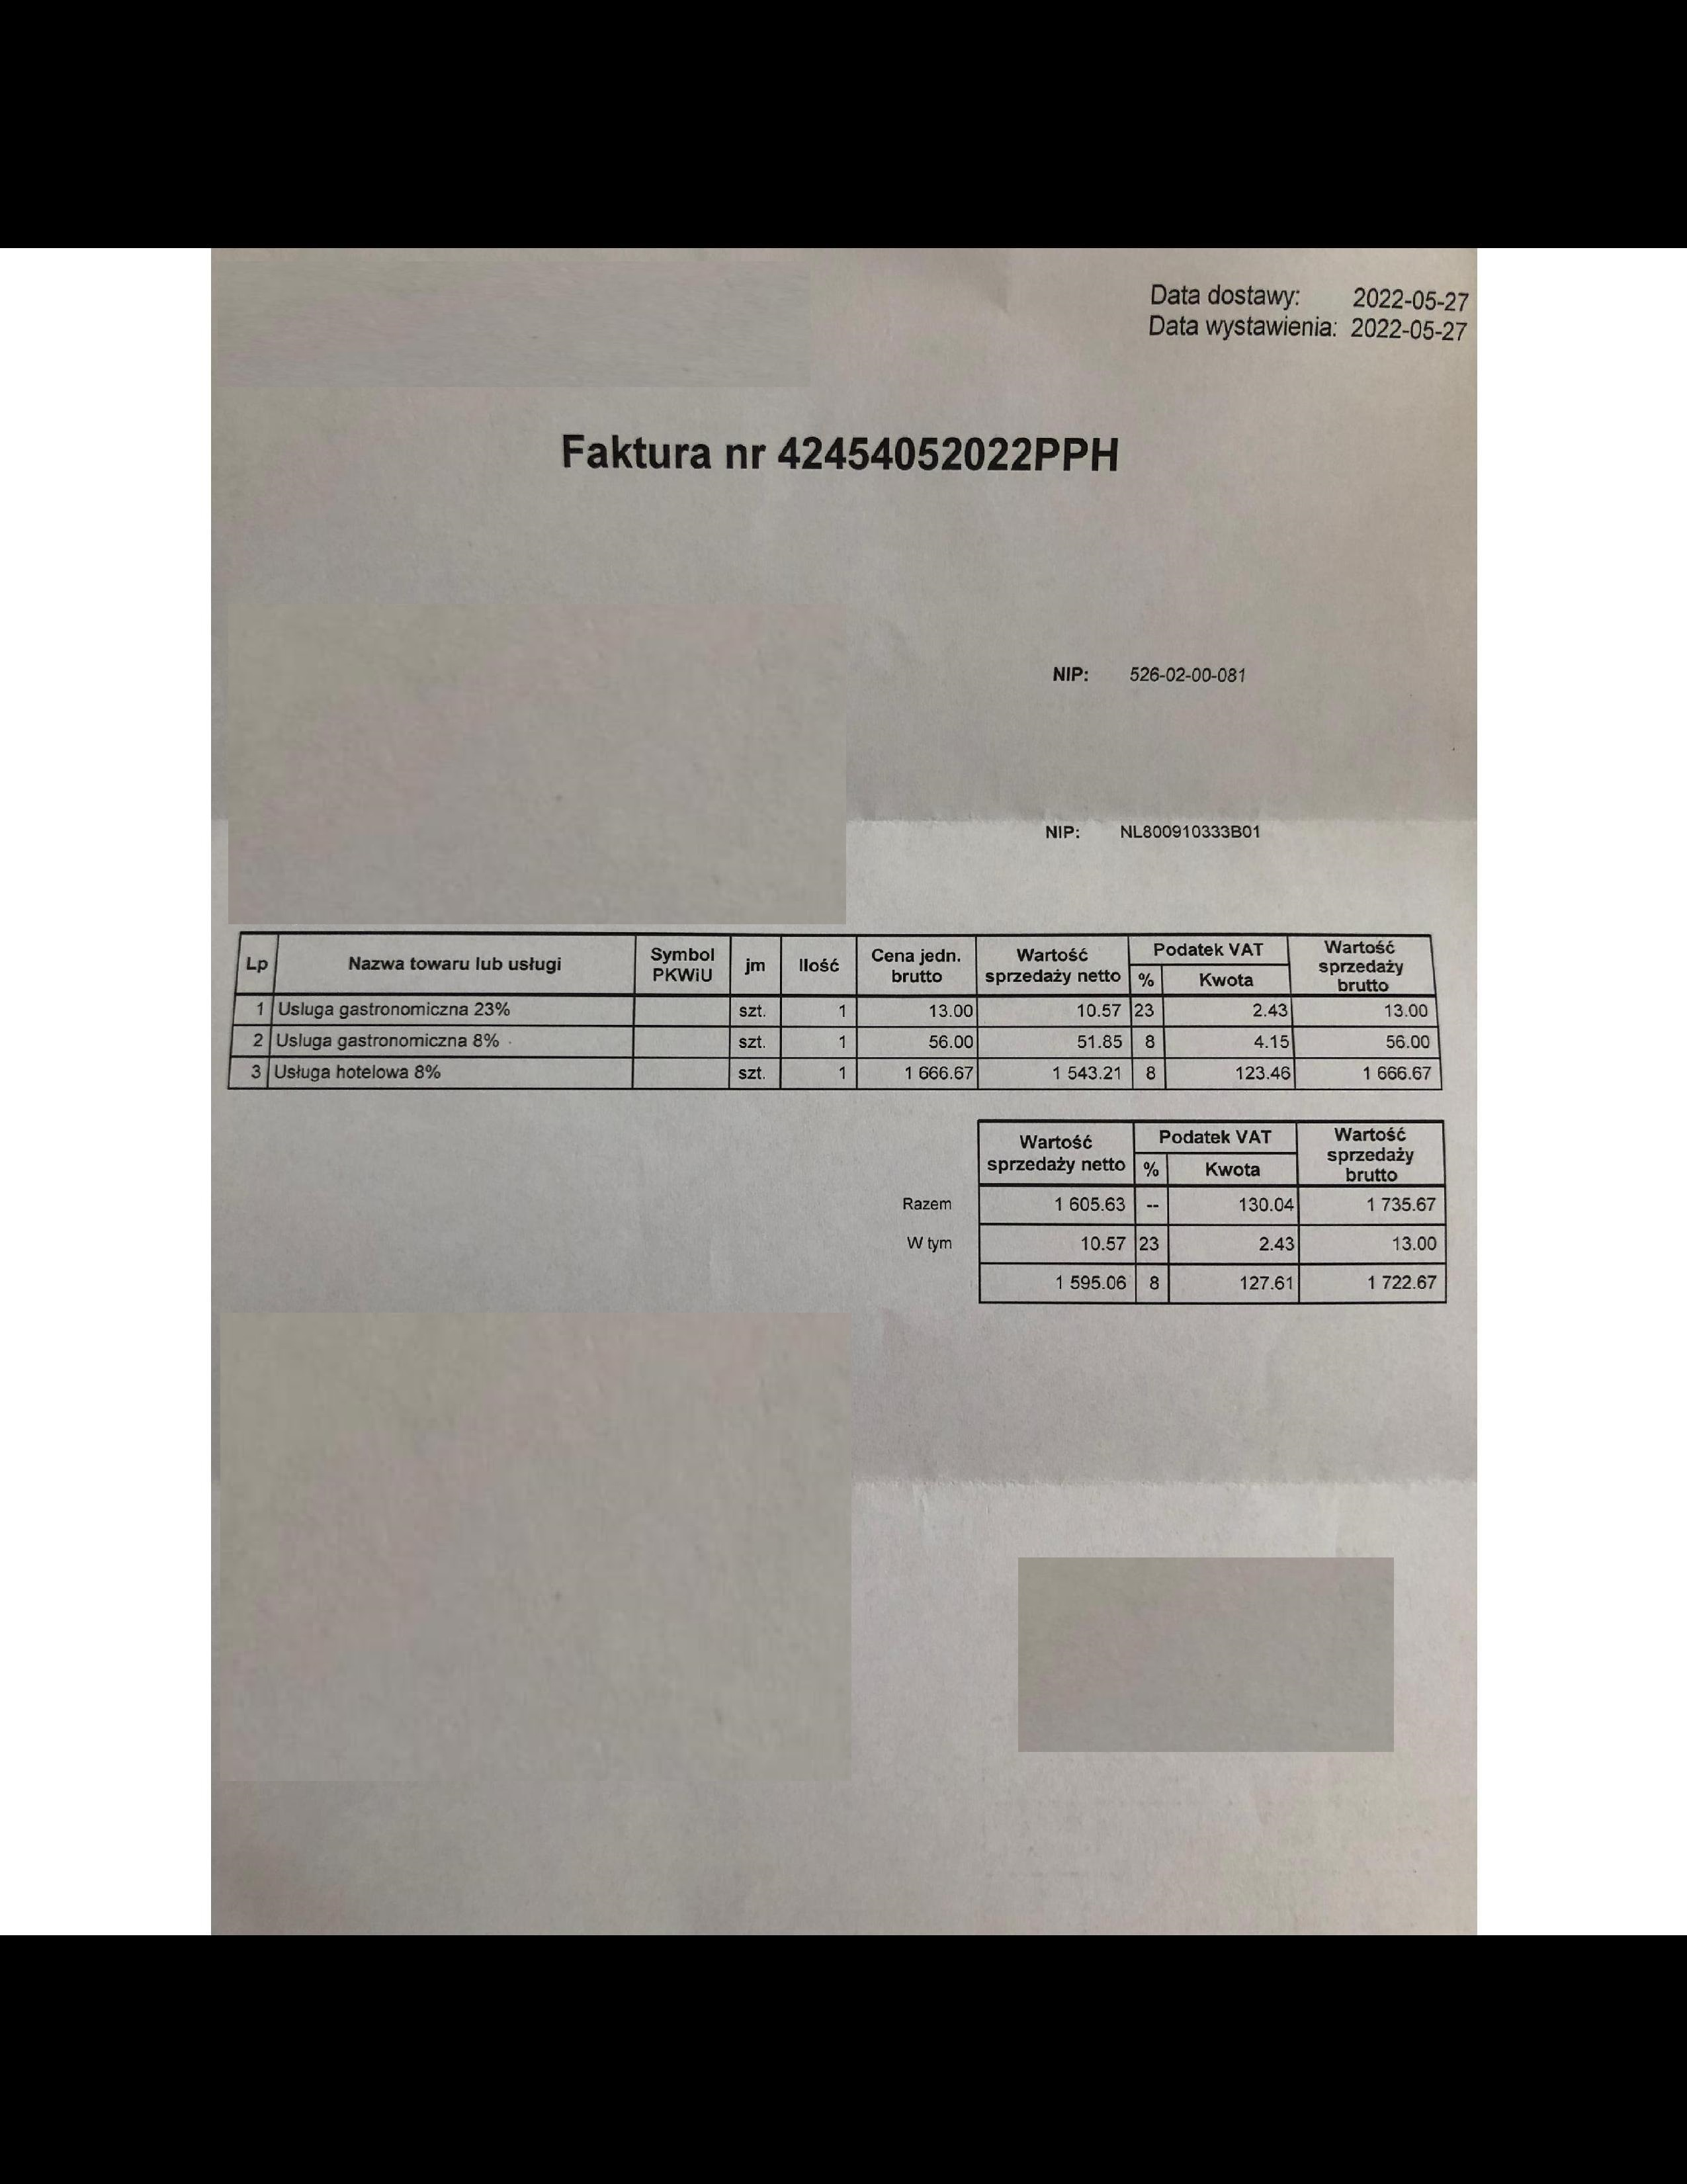
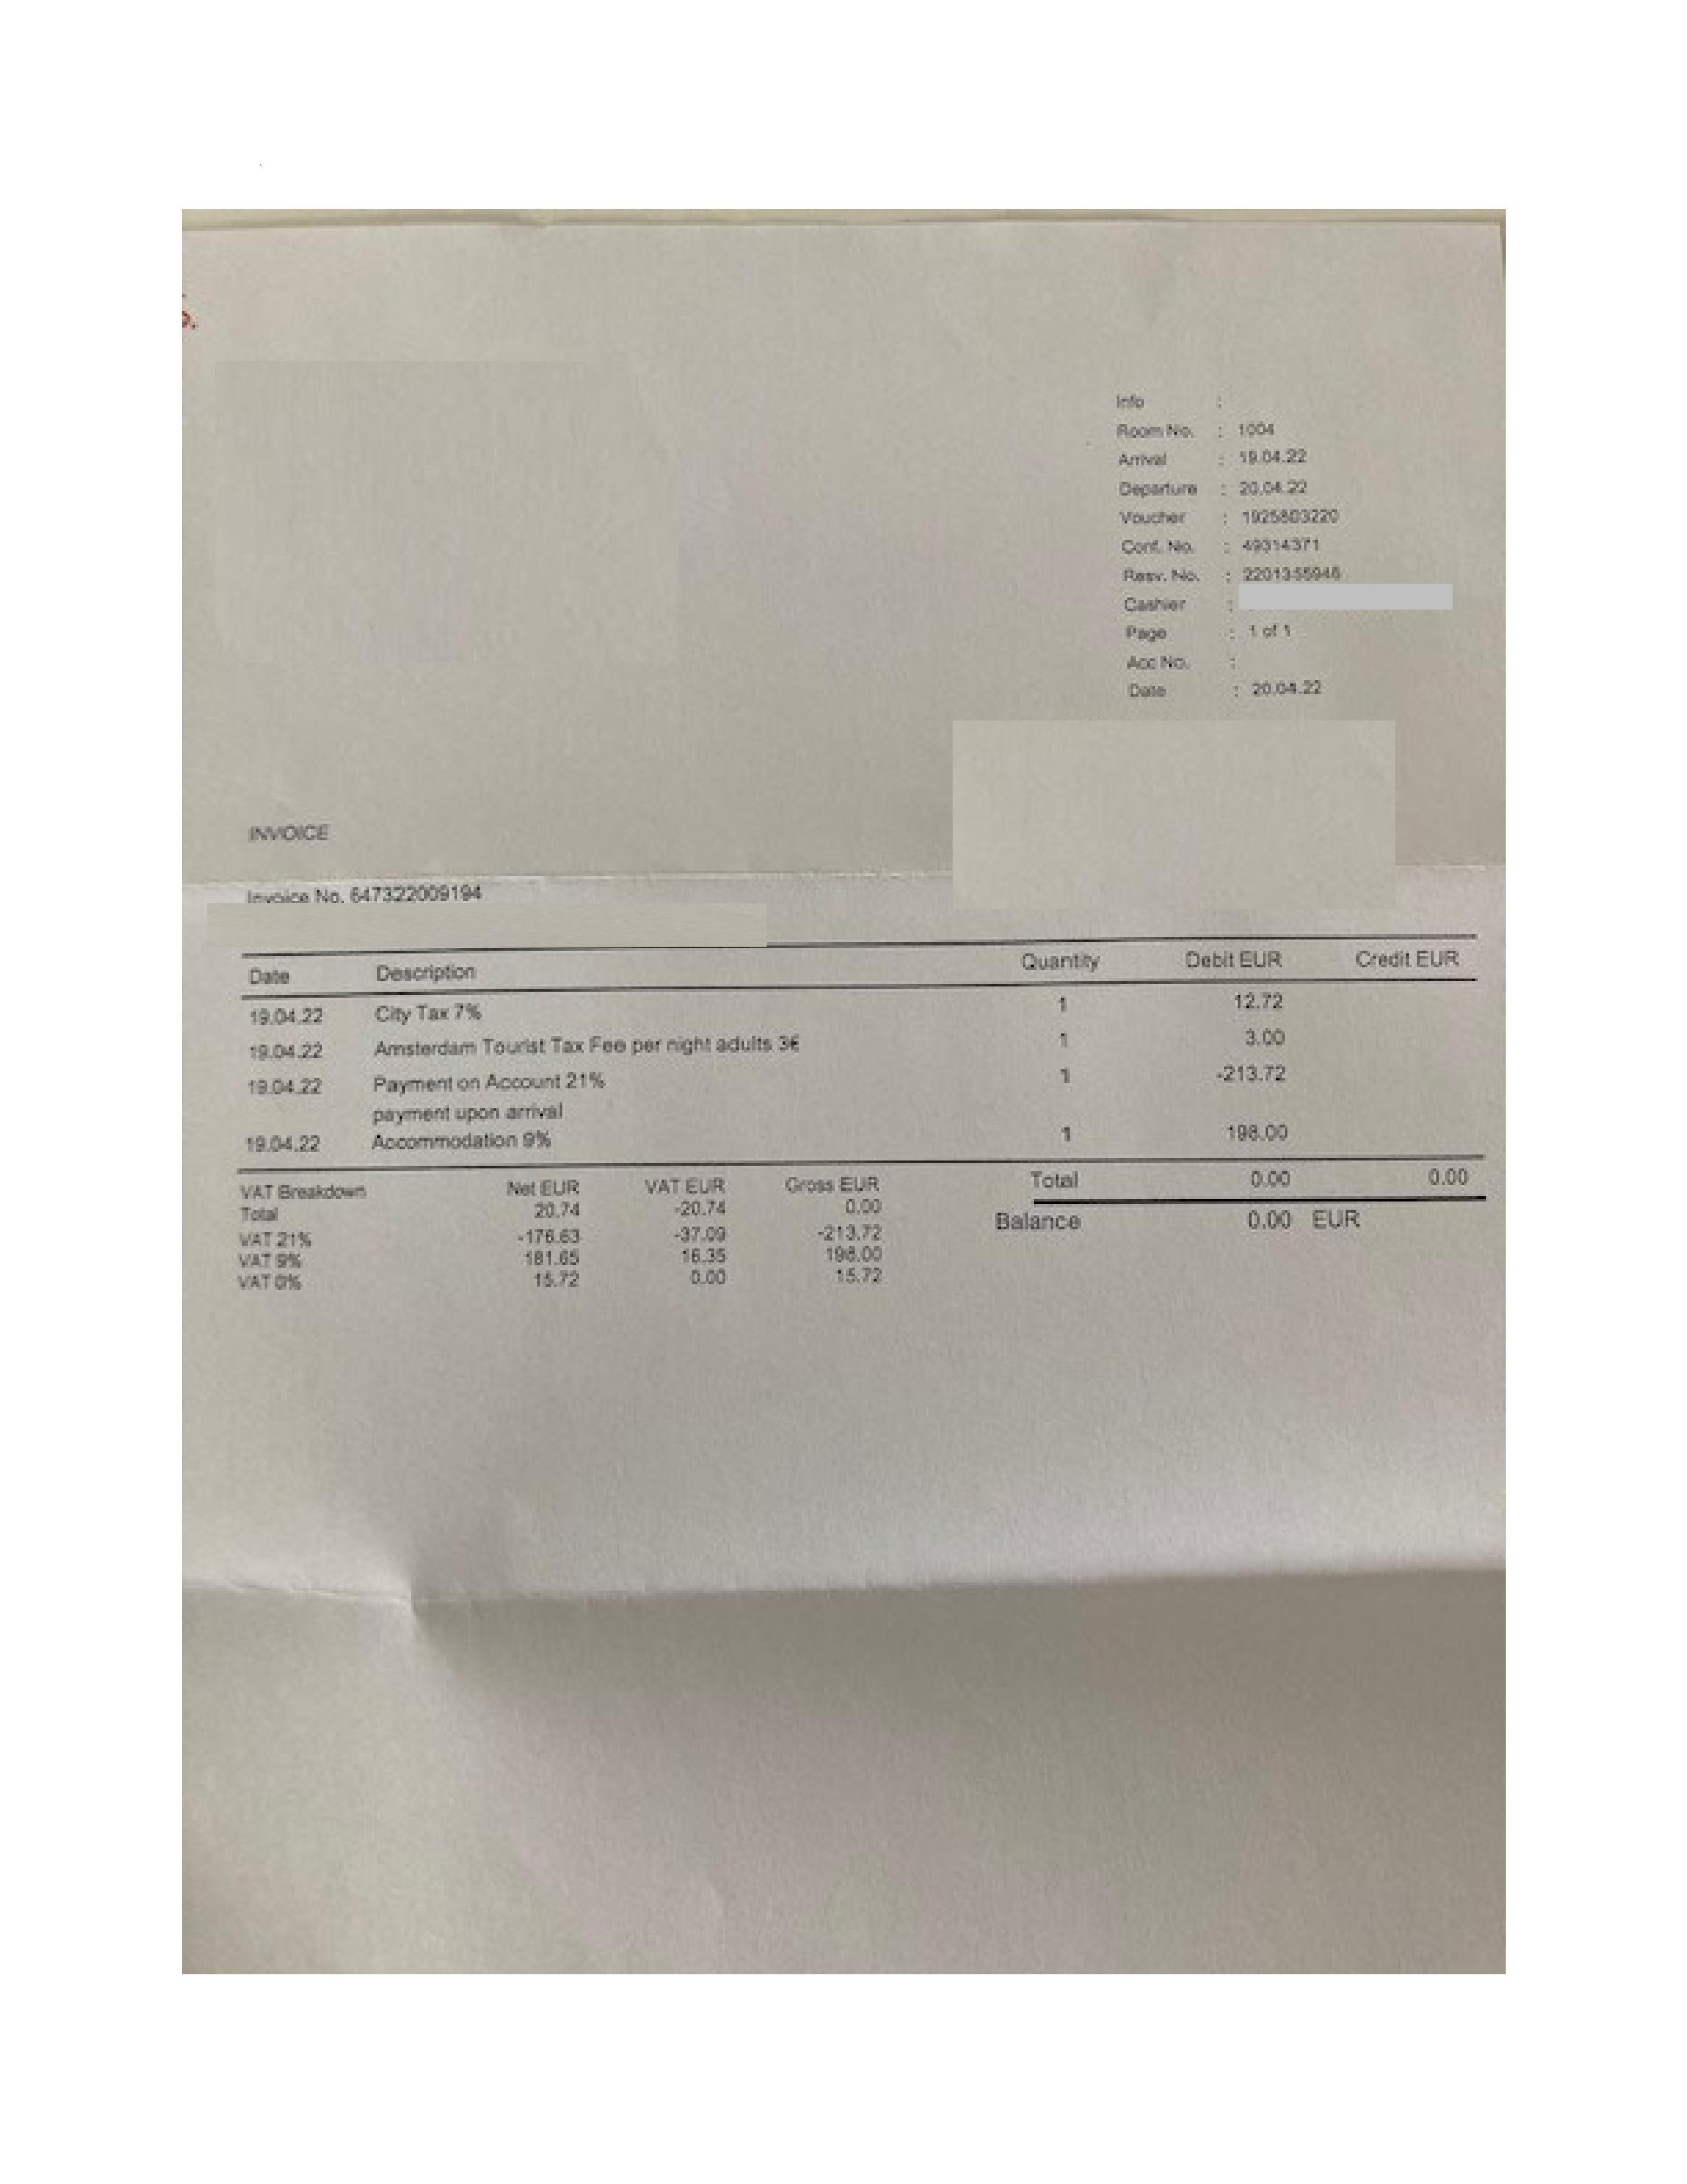

{
    "Petr1.JPG": {
        "TotalTax": {
            "invoice_document_intelligence": "6,00 \u20ac",
            "invoice_gpt4_vision": "6,00",
            "ground_truth": "6,00"
        },
        "InvoiceTotal": {
            "invoice_document_intelligence": "\u20ac",
            "invoice_gpt4_vision": "57,60",
            "ground_truth": "57,60"
        },
        "InvoiceId": {
            "invoice_document_intelligence": "108786",
            "invoice_gpt4_vision": "108786",
            "ground_truth": "108786"
        },
        "InvoiceDate": {
            "invoice_document_intelligence": "24.04.2022",
            "invoice_gpt4_vision": "24.04.2022",
            "ground_truth": "24.04.2022"
        }
    },
    "Hotel119.jpg": {
        "TotalTax": {
            "invoice_document_intelligence": "20.18",
            "invoice_gpt4_vision": "271.35",
            "ground_truth": "20.18"
        },
        "InvoiceTotal": {
            "invoice_document_intelligence": "271.35",
   

In [29]:
import time
from utils.ml_logging import get_logger

# Initialize logging
logger = get_logger()

results = {}
total_time_document_intelligence = 0
total_time_gpt_vision = 0
successes = 0
failures = 0

for document_name in document_names:
    try:
        document_local_document_name = os.path.join(document_local, document_name)
        document_blob_document_name = os.path.join(document_blob, document_name)

        start_time = time.time()
        result_ocr_invoice_document_intelligence = (
            document_intelligence_client.analyze_document(
                document_input=document_blob_document_name,
                model_type=model_type,
                output_format="markdown",
                features=["OCR_HIGH_RESOLUTION"],
            )
        )
        end_time = time.time()
        total_time_document_intelligence += end_time - start_time

        result_ocr_invoice_document_intelligence = (
            document_intelligence_client.process_invoice(
                result_ocr_invoice_document_intelligence.documents[0]
            )
        )

        start_time = time.time()
        result_ocr_invoice_gpt_4_vision = gpt_vision_client.call_gpt4v_image(
            document_local_document_name,
            system_instruction=sys_message,
            user_instruction=user_prompt,
            ocr=True,
            use_vision_api=True,
            display_image=False,
            max_tokens=3000,
            seed=42,
        )
        end_time = time.time()
        total_time_gpt_vision += end_time - start_time

        cleaned_json_string = clean_json_string(result_ocr_invoice_gpt_4_vision)
        ocr_recognizer_dict = json.loads(cleaned_json_string)
        comparison_result = compare_invoices(
            invoice_document_intelligence=result_ocr_invoice_document_intelligence,
            invoice_gpt4_vision=ocr_recognizer_dict,
            ground_truth=ground_truth_bulk[document_name],
        )

        results[document_name] = comparison_result
        successes += 1
    except Exception as e:
        logger.error(
            f"An error occurred while processing document {document_name}: {e}"
        )
        failures += 1

average_time_document_intelligence = total_time_document_intelligence / len(
    document_names
)
average_time_gpt_vision = total_time_gpt_vision / len(document_names)

logger.info(
    f"Average time taken by document_intelligence_client.analyze_document: {average_time_document_intelligence} seconds"
)
logger.info(
    f"Average time taken by gpt_vision_client.call_gpt4v_image: {average_time_gpt_vision} seconds"
)

logger.info(f"Number of successful document processing: {successes}")
logger.info(f"Number of failed document processing: {failures}")

results_json = json.dumps(results, indent=4)

print(results_json)